In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [8]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='binary_error', model_type='gbdt',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=50, categorical_features=None):
    
    lgb_params = {
        'boosting_type': model_type,
        'objective': objective,
        'metric': metrics,
        'use_missing' : True,
        'is_unbalanced ': True,
        'learning_rate': 0.05,
        'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 511,  # Number of bucketed bin for feature values
        'colsample_bytree': 0.9,
        'subsample': 0.85,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0.01,  # L1 regularization term on weights
        'reg_lambda': 0.1,  # L2 regularization term on weights
        'nthread': 40,
        'verbose': -1,
    }

    lgb_params.update(params)
    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=verbose_eval, 
                     feval=feval)

    return bst1

def model_validation(train_df,val_df,predictors,target,params):
    categorical=[]
    for item in predictors:
        if (item in CATE_LIST):
            categorical.append(item)
            
    '''
    if (target == 'Normal'):
        params = {
            'scale_pos_weight' : 0.013,
        } 
    else:
        params = {
            'scale_pos_weight' : 120,
        }
    '''
    bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        model_type='dart',
                        objective='binary', 
                        #metrics ='binary',
                        metrics={'auc'},
                        early_stopping_rounds=1000, 
                        verbose_eval=50, 
                        num_boost_round=10000, 
                        categorical_features=categorical
                        )
    y_predict = bst.predict(val_df[predictors])
    if (target == 'Normal'):
        y_predict = 1 - y_predict
    atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],y_predict)
    return bst,atec_Score

In [9]:
train_df = pd.read_pickle('./01_train.dat')

predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])


(634284, 360447)

In [10]:
WOE_LIST = joblib.load('./woe_feature.dat')

In [11]:
CATE_LIST = WOE_LIST + atecml.data.CATE_FEATURE_LIST

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.989807	valid's auc: 0.977982
[100]	train's auc: 0.990476	valid's auc: 0.979263
[150]	train's auc: 0.990575	valid's auc: 0.979512
[200]	train's auc: 0.990709	valid's auc: 0.979495
[250]	train's auc: 0.991195	valid's auc: 0.979572
[300]	train's auc: 0.992516	valid's auc: 0.978997
[350]	train's auc: 0.993395	valid's auc: 0.978654
[400]	train's auc: 0.994688	valid's auc: 0.978951
[450]	train's auc: 0.995701	valid's auc: 0.980284
[500]	train's auc: 0.996384	valid's auc: 0.980452
[550]	train's auc: 0.996892	valid's auc: 0.980439
[600]	train's auc: 0.997159	valid's auc: 0.980528
[650]	train's auc: 0.99749	valid's auc: 0.981032
[700]	train's auc: 0.997735	valid's auc: 0.981328
[750]	train's auc: 0.997956	valid's auc: 0.981968
[800]	train's auc: 0.998136	valid's auc: 0.982305
[850]	train's auc: 0.998327	valid's auc: 0.982469
[900]	train's auc: 0.998506	valid's auc: 0.982566
[950]	tr

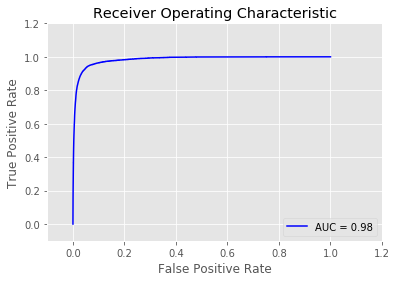

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.988882	valid's auc: 0.971304
[100]	train's auc: 0.989598	valid's auc: 0.974223
[150]	train's auc: 0.989653	valid's auc: 0.97449
[200]	train's auc: 0.98987	valid's auc: 0.974038
[250]	train's auc: 0.99083	valid's auc: 0.973661
[300]	train's auc: 0.992207	valid's auc: 0.974138
[350]	train's auc: 0.993154	valid's auc: 0.975354
[400]	train's auc: 0.994221	valid's auc: 0.977159
[450]	train's auc: 0.995249	valid's auc: 0.978273
[500]	train's auc: 0.995952	valid's auc: 0.979156
[550]	train's auc: 0.996546	valid's auc: 0.979253
[600]	train's auc: 0.996817	valid's auc: 0.979012
[650]	train's auc: 0.997208	valid's auc: 0.979336
[700]	train's auc: 0.997469	valid's auc: 0.979808
[750]	train's auc: 0.997699	valid's auc: 0.980294
[800]	train's auc: 0.99788	valid's auc: 0.98081
[850]	train's auc: 0.998095	valid's auc: 0.980996
[900]	train's auc: 0.998275	valid's auc: 0.981365
[950]	train'

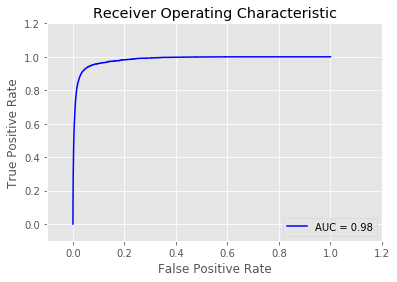

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.988178	valid's auc: 0.972666
[100]	train's auc: 0.989437	valid's auc: 0.975491
[150]	train's auc: 0.989543	valid's auc: 0.975626
[200]	train's auc: 0.989778	valid's auc: 0.975709
[250]	train's auc: 0.990476	valid's auc: 0.974831
[300]	train's auc: 0.991768	valid's auc: 0.974617
[350]	train's auc: 0.99284	valid's auc: 0.975278
[400]	train's auc: 0.994069	valid's auc: 0.977653
[450]	train's auc: 0.995171	valid's auc: 0.979198
[500]	train's auc: 0.996014	valid's auc: 0.980376
[550]	train's auc: 0.996642	valid's auc: 0.980124
[600]	train's auc: 0.996937	valid's auc: 0.980321
[650]	train's auc: 0.997333	valid's auc: 0.98103
[700]	train's auc: 0.997593	valid's auc: 0.980968
[750]	train's auc: 0.997851	valid's auc: 0.980777
[800]	train's auc: 0.998032	valid's auc: 0.980921
[850]	train's auc: 0.99827	valid's auc: 0.981539
[900]	train's auc: 0.998466	valid's auc: 0.981574
[950]	trai

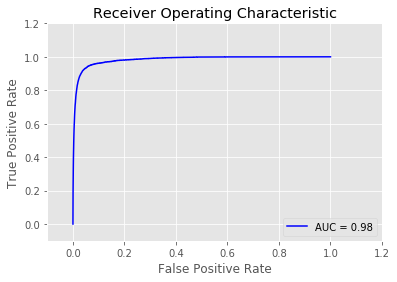

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.988105	valid's auc: 0.974344
[100]	train's auc: 0.989008	valid's auc: 0.97579
[150]	train's auc: 0.989118	valid's auc: 0.976281
[200]	train's auc: 0.98943	valid's auc: 0.975817
[250]	train's auc: 0.990024	valid's auc: 0.976559
[300]	train's auc: 0.991746	valid's auc: 0.976974
[350]	train's auc: 0.992596	valid's auc: 0.977875
[400]	train's auc: 0.993847	valid's auc: 0.978832
[450]	train's auc: 0.994978	valid's auc: 0.979989
[500]	train's auc: 0.995776	valid's auc: 0.980868
[550]	train's auc: 0.996423	valid's auc: 0.981312
[600]	train's auc: 0.996724	valid's auc: 0.981156
[650]	train's auc: 0.997134	valid's auc: 0.981512
[700]	train's auc: 0.997394	valid's auc: 0.982035
[750]	train's auc: 0.997657	valid's auc: 0.982307
[800]	train's auc: 0.997873	valid's auc: 0.9826
[850]	train's auc: 0.998114	valid's auc: 0.982872
[900]	train's auc: 0.998307	valid's auc: 0.98292
[950]	train'

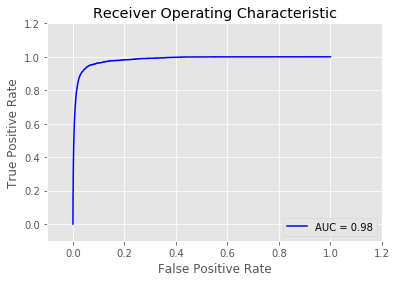

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.988811	valid's auc: 0.971958
[100]	train's auc: 0.989374	valid's auc: 0.973693
[150]	train's auc: 0.989378	valid's auc: 0.974244
[200]	train's auc: 0.989729	valid's auc: 0.974142
[250]	train's auc: 0.990331	valid's auc: 0.973284
[300]	train's auc: 0.991719	valid's auc: 0.973962
[350]	train's auc: 0.992728	valid's auc: 0.975157
[400]	train's auc: 0.993857	valid's auc: 0.97694
[450]	train's auc: 0.995051	valid's auc: 0.978657
[500]	train's auc: 0.995844	valid's auc: 0.979462
[550]	train's auc: 0.99644	valid's auc: 0.980161
[600]	train's auc: 0.996724	valid's auc: 0.979979
[650]	train's auc: 0.997113	valid's auc: 0.980396
[700]	train's auc: 0.997392	valid's auc: 0.980633
[750]	train's auc: 0.997655	valid's auc: 0.981327
[800]	train's auc: 0.99785	valid's auc: 0.981025
[850]	train's auc: 0.998057	valid's auc: 0.98095
[900]	train's auc: 0.998267	valid's auc: 0.981099
[950]	train

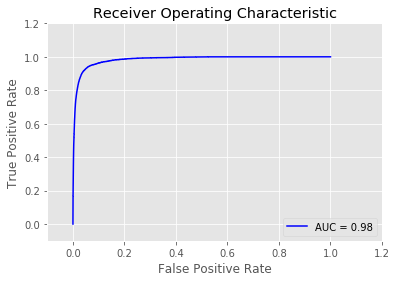

In [12]:
pos_model_list  =[]
neg_model_list  =[]
score_posA = []
score_negA = []

for idx in range(0,5):
    Train_DataSet = train_df[train_df.index.isin(list(all_list - DateFold[idx]))].reset_index(drop=True)
    Val_DataSet = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)
    #model_pos,score_pos = model_validation(Train_DataSet,Val_DataSet,predictors,'Normal',{})
    #pos_model_list.append(model_pos)
    #score_posA.append(score_pos)   
    model_neg,score_neg = model_validation(Train_DataSet,Val_DataSet,predictors,'Fraud',{})    
    neg_model_list.append(model_neg)    
    score_negA.append(score_neg)
    

In [13]:
import joblib
#joblib.dump(pos_model_list,'./pos_model_list.dat')
#joblib.dump(score_posA,'./score_pos.dat')
joblib.dump(neg_model_list,'./neg_model_list.dat')
joblib.dump(score_negA,'./score_neg.dat')

['./score_neg.dat']

In [17]:
val_df = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)

val_r_pos=pd.DataFrame()
val_r_neg=pd.DataFrame()

for idx in tqdm(range(0,len(neg_model_list))):
    #model_pos = pos_model_list[idx]
    model_neg = neg_model_list[idx]
    #val_pos = model_pos.predict(val_df[predictors],num_iteration=model_pos.best_iteration)
    val_neg = model_neg.predict(val_df[predictors],num_iteration=model_neg.best_iteration)
    #val_r_pos[idx] = 1 - val_pos
    val_r_neg[idx] = val_neg

100%|██████████| 5/5 [01:45<00:00, 21.16s/it]


In [18]:
#pos_mean = val_r_pos.mean(axis=1)
neg_mean = val_r_neg.mean(axis=1)

Ant-Score: 0.516549220585095


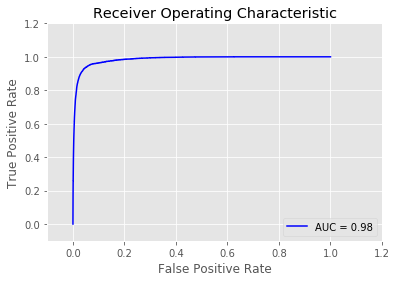

In [19]:
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],neg_mean)

In [20]:
from sklearn.ensemble import VotingClassifier

In [21]:
voting_clf=VotingClassifier(estimators=[('a1',neg_model_list[0]),('rf',neg_model_list[1]),('svc',neg_model_list[2])],voting='soft')


In [25]:
voting_clf.fit(val_df[predictors],val_df['Fraud'])

TypeError: Cannot clone object '<lightgbm.basic.Booster object at 0x7f429577b0b8>' (type <class 'lightgbm.basic.Booster'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

In [26]:
foo = neg_model_list[1]

In [30]:
foo.feature_importance()

array([ 588,  523,  739, 1664,  632, 1595, 3183,  763,  795,  694, 1141,
        752,  593, 1636, 2249,  536, 1290, 1753, 1773,  237,  405,  230,
        307,  567,  814,  757,  749,  349,  384, 1078, 1126,  515,  538,
        457,  459,    5,   11,   19,   13,    1,   18,   19,   34,    9,
         22,   41,   34,  549,  445,  549,  390, 1024,  996,  809,  501,
        366,  450,  621,   61,  184,   26,  265,  318,  169,  185,  200,
        102,  132,  136,  105,  133,  184,  285,  215,  202,  299,  281,
        228,  224,  623, 1100, 1862,  707,  939,  999,  979,    7,    3,
         33,   63,  238,   91,   83,   65,  116,  168,  124,   73,  285,
        376,  978,  317,  386,  470,  633, 1396,  158,  192,  182,  451,
         56,   65,  175,   96,   61,   70,   80,   68,   71,  124,   90,
         66,   61,  113,  128,   88,  151,  118,   64,  125,  131,  138,
        117,  216,   69,   52,   82,  109,  103,   78,   79,  132,  116,
        157,  152,  125,  102,  201,   83,   72,  1

In [ ]:
test_df = pd.read_pickle('./01_test.dat')

In [ ]:
test_r_pos=pd.DataFrame()
test_r_neg=pd.DataFrame()

for idx in tqdm(range(0,len(pos_model_list))):
    #model_pos = pos_model_list[idx]
    model_neg = neg_model_list[idx]
    #test_pos = model_pos.predict(test_df[predictors],num_iteration=model_pos.best_iteration)
    test_neg = model_neg.predict(test_df[predictors],num_iteration=model_neg.best_iteration)
    #test_r_pos[idx] = 1 - test_pos
    test_r_neg[idx] = test_neg

In [ ]:
neg_mean = test_r_neg.mean(axis=1)

In [ ]:
result=pd.DataFrame()
result['id'] = test_df['id']
result['score'] = neg_mean

In [ ]:
result[['id','score']].to_csv('./submit_2018_07_05_01.csv',index=False)

In [ ]:
result